### Import Libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Create Individual


* using 64 bit string with binary permutation representation.
* each bit represents a cell on the chess board.
* each consecutive 8bits represent a row so we have: |row0|row1|row2|row3|row4|row5|row7|row8| in each chromosome.
* 1 indicates queen in that cell.







In [2]:
def create_individual():
    # TODO: create a random chromosome
    ch = np.array([1]*8 + [0]*56)
    np.random.shuffle(ch)
    print (ch)
    return ch

### Generate Population

In [3]:
def generate_population(population_size:int = 20):
    population = []
    for _ in range(population_size):
        new_individual = create_individual()
        population.append(new_individual)
    return population

### Parent Selection

applying a rank based selection algorithm which returns two parents with highest fitness_score each time

In [19]:
def parent_selection(population):

    parents = []
    #TODO: choose the pairs of parents
    # get parents scores and sort them in a descending manner
    individual_scores, _ = population_fitness(population)
    sorted_items = sorted(individual_scores.items(), key=lambda item: item[1], reverse=True)

    # Extract the chromosomes of the top 2 parents
    chromosomes = [item[0] for item in sorted_items[:2]]

    # Convert the chromosomes to numpy arrays and add them to selected parents
    for ch in chromosomes:
        parents.append(np.array(list(ch), dtype=int))

    # Remove the selected parents from the population
    for parent in parents:
      index_to_remove = next((i for i, arr in enumerate(population) if (arr == parent).all()), None)
      if index_to_remove is not None:
        del population[index_to_remove]

    return parents

### Next Generation Selection

performing sel(μ + γ) method for choosing next generation amongst chosen parents and created children

In [18]:
def next_generation_selection(children_population, parents_population):
    next_generation = []
    #TODO: choose the next_generation

    # sort parents and children based on their fitness score
    population = children_population + parents_population
    individual_scores, _ = population_fitness(population)
    sorted_items = sorted(individual_scores.items(), key=lambda item: item[1], reverse=True)

    # Extract the chromosomes of the top 2
    chromosomes = [item[0] for item in sorted_items[:2]]

    # Convert the chromosomes to numpy arrays
    for ch in chromosomes:
        next_generation.append(np.array(list(ch), dtype=int))

    return next_generation

### Crossover

choosing order1 crossover technique for permutation based representation.
some modifications have been applied to match the number of 1s in the chromosome.

In [6]:
# function to perform part of order1 crossover
def fill_child(child, parent, start, end):
        remaining_ones = 8 - np.count_nonzero(child[start:end] == 1)
        remaining_zeros = 56 - np.count_nonzero(child[start:end] == 0)

        current_pos = end
        for gene in parent:
          if (gene == 1 and remaining_ones > 0) or (gene == 0 and remaining_zeros > 0):
            while child[current_pos] != -1:  # assuming -1 is the placeholder for empty positions
                current_pos = (current_pos + 1) % len(child)
            child[current_pos] = gene
            if gene == 1:
                remaining_ones -= 1
            else:
                remaining_zeros -= 1
            current_pos = (current_pos + 1) % len(child)
        return child

In [7]:
def crossover(parents):
    offsprings = []
    #TODO: implement you crossover algorithm

    parent1 = parents[0].copy()
    parent2 = parents[1].copy()
    length = len(parent1)
    child1 = np.full_like(parent1, -1)
    child2 = np.full_like(parent2, -1)

    # Randomly select crossover points
    start, end = sorted(np.random.choice(range(length), 2, replace=False))

    # Copy the crossover segment from parent1 to child1, and parent2 to child2
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Fill the remaining positions in child1 with the genes from parent2
    child1 = fill_child(child1, parent2, start, end)
    # Fill the remaining positions in child2 with the genes from parent1
    child2 = fill_child(child2, parent1, start, end)

    offsprings.append(child1)
    offsprings.append(child2)

    return offsprings

### Mutation

performing swap mutation on binary permutation based representation

In [8]:
def mutate_child(child, mutation_rate):
    mutated = np.copy(child)
    if np.random.rand() < mutation_rate:
        # randomly select two indices
        a, b = sorted(np.random.choice(range(len(child)), 2, replace=False))
        # swap the values at the selected indices
        mutated[a], mutated[b] = mutated[b], mutated[a]

    return mutated

In [9]:
def mutate(children, mutation_rate):
    #TODO: implement mutate
    mutated_children = []
    for child in children:
        mutated_child = mutate_child(child, mutation_rate)
        mutated_children.append(mutated_child)
    return mutated_children

### Score Function

In [15]:
def fitness_score(seq):
    #print("fitness svore\n")
    #print(type(seq))
    # converting 64 bit array to 8*8 chess board. calculating the queens positions'
    board_size = 8
    arr = seq.tolist()
    queens_positions = [(i // board_size, i % board_size) for i in range(len(arr)) if arr[i] == 1]

    # declaring dictionaries for # of conflicts in each row, column and diagonal
    row_counts = {}
    col_counts = {}
    main_diag_counts = {}
    anti_diag_counts = {}

    # count the number of queens in each row, column and diagonal
    for (row, col) in queens_positions:
        row_counts[row] = row_counts.get(row, 0) + 1
        col_counts[col] = col_counts.get(col, 0) + 1
        main_diag_counts[row - col] = main_diag_counts.get(row - col, 0) + 1
        anti_diag_counts[row + col] = anti_diag_counts.get(row + col, 0) + 1

    # number of conflicts in each row, column and diagona = number of queens - 1
    conflicts = 0
    for count in row_counts.values():
        if count > 1:
            conflicts += count - 1
    for count in col_counts.values():
        if count > 1:
            conflicts += count - 1
    for count in main_diag_counts.values():
        if count > 1:
            conflicts += count - 1
    for count in anti_diag_counts.values():
        if count > 1:
            conflicts += count - 1

    #TODO: calculate fitness score
    # chromosomes with minimum conflicts have highest fitness score
    fit_score = 28 - conflicts

    return fit_score

## Calculate Population Fitness

In [11]:
def population_fitness(population):
    population_fitness = 0
    individuals_fitnesses:dict = {}
    for chromosome in population:
        fitness_sc = fitness_score(chromosome)
        population_fitness += fitness_sc
        individuals_fitnesses[''.join(map(str, chromosome))] = fitness_sc
    return individuals_fitnesses ,population_fitness

### Termination Condition

In [24]:
def check_end(population, generation_num, avg_fit) -> bool:
    #TODO: check end of algorithm

    return avg_fit >= 28 or generation_num > 5000

### Run Your Algorithms

In [25]:
# The genetic algorithm
generation = 0
solution_is_found = False
fitness = []
mutation_rate = 0.1

population = generate_population()
individuals_fitnesses , population_fit = population_fitness(population)

while not check_end(population, generation, avg_fit):
    # TODO: this is a default setup which you maybe need to change.
    parents_population = parent_selection(population)
    children_population = crossover(parents_population)
    children_population = mutate(children_population, mutation_rate)
    next_gen = next_generation_selection(children_population, parents_population)
    population = population + next_gen
    individuals_fitnesses , population_fit = population_fitness(population)


    generation += 1
    avg_fit = population_fit / population.__len__()
    fitness.append(avg_fit)
    print(f"Generation: {generation}, Average Fitness: {avg_fit}")


Streaming output truncated to the last 5000 lines.
Generation: 2, Average Fitness: 19.2
Generation: 3, Average Fitness: 19.2
Generation: 4, Average Fitness: 19.25
Generation: 5, Average Fitness: 19.3
Generation: 6, Average Fitness: 19.3
Generation: 7, Average Fitness: 19.3
Generation: 8, Average Fitness: 19.35
Generation: 9, Average Fitness: 19.35
Generation: 10, Average Fitness: 19.4
Generation: 11, Average Fitness: 19.4
Generation: 12, Average Fitness: 19.4
Generation: 13, Average Fitness: 19.4
Generation: 14, Average Fitness: 19.4
Generation: 15, Average Fitness: 19.4
Generation: 16, Average Fitness: 19.4
Generation: 17, Average Fitness: 19.4
Generation: 18, Average Fitness: 19.4
Generation: 19, Average Fitness: 19.4
Generation: 20, Average Fitness: 19.4
Generation: 21, Average Fitness: 19.4
Generation: 22, Average Fitness: 19.4
Generation: 23, Average Fitness: 19.4
Generation: 24, Average Fitness: 19.4
Generation: 25, Average Fitness: 19.4
Generation: 26, Average Fitness: 19.4
Gene

### See Your Progress Over Generations

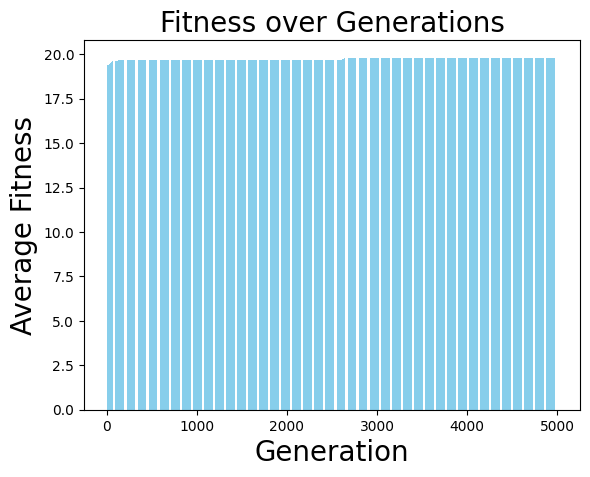

In [26]:
plt.bar(range(generation), fitness, color='skyblue')
plt.xlabel('Generation', fontsize=20)
plt.ylabel('Average Fitness', fontsize=20)
plt.title('Fitness over Generations', fontsize=20)
plt.show()